In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import wcs
from astropy.io import ascii
from astropy.table import Table, Column, MaskedColumn
from pathlib import Path
from math import trunc
%matplotlib inline

In [6]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia

# Coords of J0600: 90.00316332976436 -31.007910088843165
coord = SkyCoord(ra=90.003163, dec=-31.007910, unit=(u.degree, u.degree), frame='icrs')
radius = u.Quantity(400, u.arcsec)
j = Gaia.cone_search_async(coord, radius)
Gaia.ROW_LIMIT = -1
r = j.get_results()
r.pprint()


INFO: Query finished. [astroquery.utils.tap.core]
    solution_id             designation          ...          dist         
                                                 ...                       
------------------- ---------------------------- ... ----------------------
1635721458409799680 Gaia DR2 2891196718939580672 ... 0.00013201426578689563
1635721458409799680 Gaia DR2 2891196684579844864 ...   0.009094052279059428
1635721458409799680 Gaia DR2 2891196753298345472 ...   0.010658205399898254
1635721458409799680 Gaia DR2 2891196684579845376 ...   0.011317279008876314
1635721458409799680 Gaia DR2 2891196753297490304 ...   0.012358430209092582
1635721458409799680 Gaia DR2 2891196920800325760 ...   0.013193050363307734
1635721458409799680 Gaia DR2 2891196753299317632 ...   0.013872023467184842
1635721458409799680 Gaia DR2 2891196680282145152 ...    0.01664899863064252
1635721458409799680 Gaia DR2 2891196684578034688 ...   0.016696369787614993
1635721458409799680 Gaia DR2 289119692

In [42]:
filt = ['gp', 'ip', 'rp']
standards = ascii.read("standards.txt")
#print (standards)

selecteds_mask = ascii.read("selected_stars.txt")
print (selecteds_mask)
mask = {}
for f in filt:
    mask[f] = np.array(selecteds_mask[f], dtype=bool)


 gp  ip  rp
--- --- ---
  0   0   0
  0   0   0
  0   0   0
  0   0   0
  0   0   0
  0   0   0
  0   0   0
  0   0   0
  0   0   0
  0   0   0
... ... ...
  0   0   0
  0   0   0
  0   0   0
  1   1   0
  0   0   0
  0   0   0
  0   0   0
  0   0   0
  0   0   0
  0   0   0
  0   0   0
Length = 161 rows


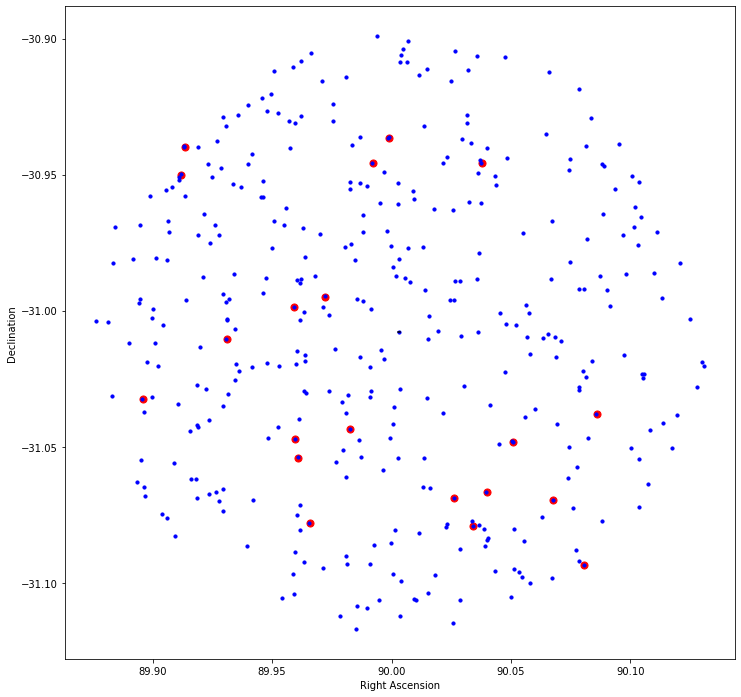

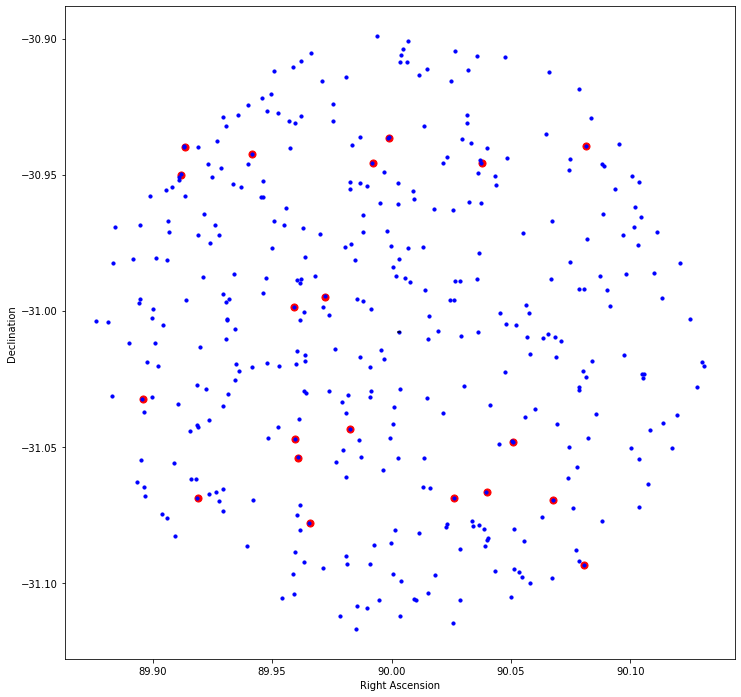

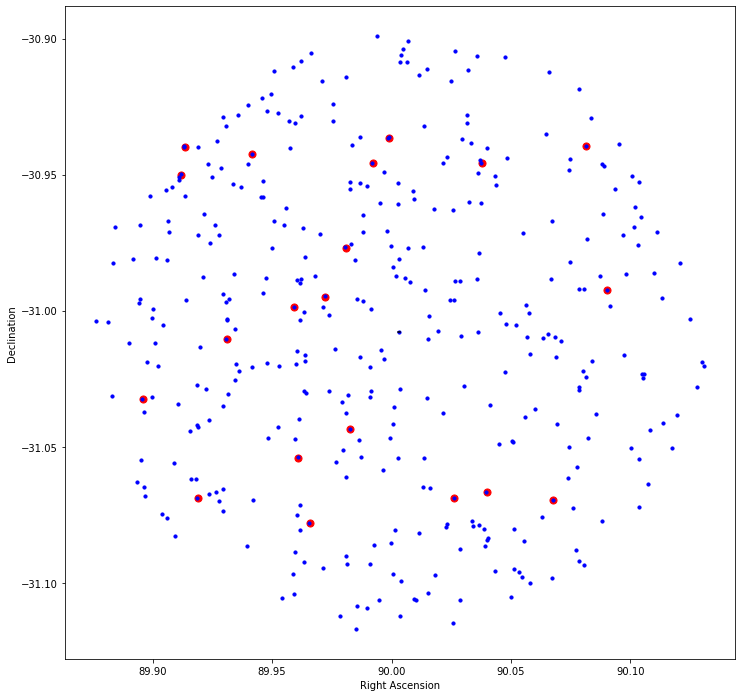

In [49]:
for f in filt:
    plt.figure(figsize=(12,12))
    #plt.scatter(standards['RA'][0],standards['Dec'][0], c='r',s=15)
    plt.scatter(standards['RA'][mask[f]],standards['Dec'][mask[f]], c='r',s=50)
    plt.scatter(r['ra'],r['dec'],c='b',s=10)
    plt.plot([standards['RA'][0]-1./3600,standards['RA'][0]+1./3600],[standards['Dec'][0],standards['Dec'][0]],c='black')
    plt.xlabel("Right Ascension")
    plt.ylabel("Declination")
    plt.show()

In [50]:
def find_stars(xobj_list, yobj_list, xlist, ylist, f):
    # Make a matrix with each column the same xlist or ylist.
    # The number of columns is the number of objects in standards.txt
    xmatrix = np.array(list(xlist)*len(xobj_list)).reshape([len(xobj_list),len(xlist)]).transpose()
    ymatrix = np.array(list(ylist)*len(yobj_list)).reshape([len(yobj_list),len(ylist)]).transpose()
    
    distance_matrix = np.sqrt((xmatrix-xobj_list)**2 + (ymatrix-yobj_list)**2)
    
    indices = np.argmin(distance_matrix, axis=0)
    """
    # Make plot to check data
    plt.figure(figsize=(16,16))
    plt.scatter(xlist,ylist,c='b',s=4)
    plt.scatter(xobj_list, yobj_list, c='red', s=2)
    plt.plot([2000,2025],[0,0],c='r')
    for i in range(nr_stars):
    	plt.plot([xobj_list[i],xlist[indices[i]]],[yobj_list[i],ylist[indices[i]]], linestyle='dashed',c='r',linewidth=1)
    plt.title(f)
    plt.show()
    """
    return indices, np.diag(distance_matrix[indices])
    #the diagonal gives the distance from each selected object to the closest object

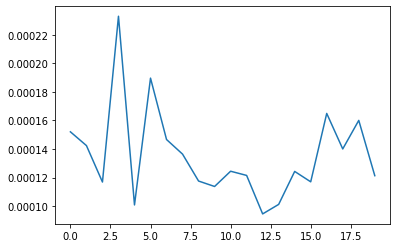

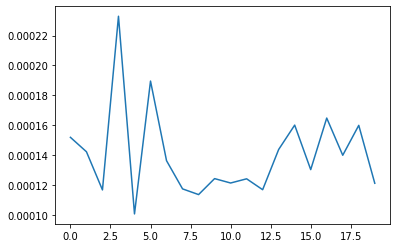

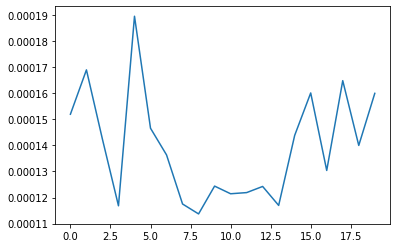

In [51]:
gaiamask = {}
for f in filt:
    stars_arg, d = find_stars(standards['RA'][mask[f]],standards['Dec'][mask[f]],r['ra'],r['dec'],f)
    gaiamask[f] = stars_arg
    plt.plot(d)
    plt.show()

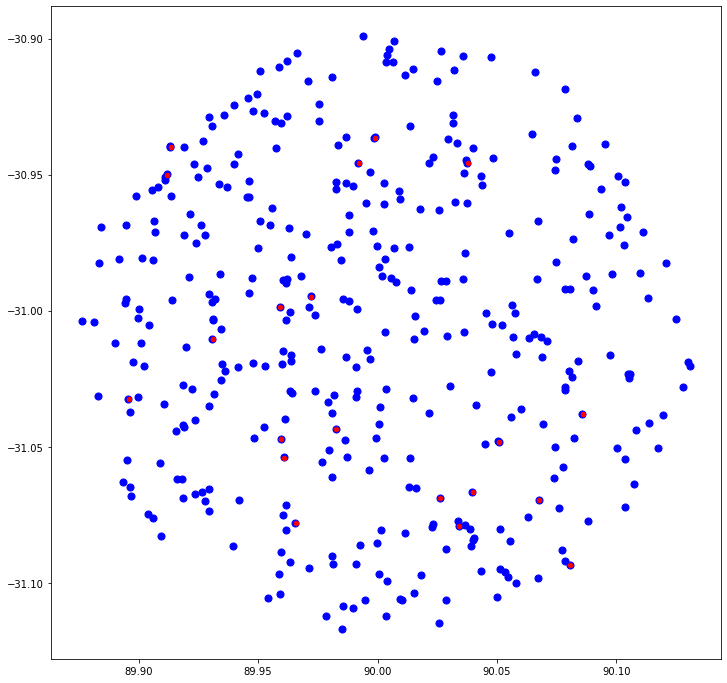

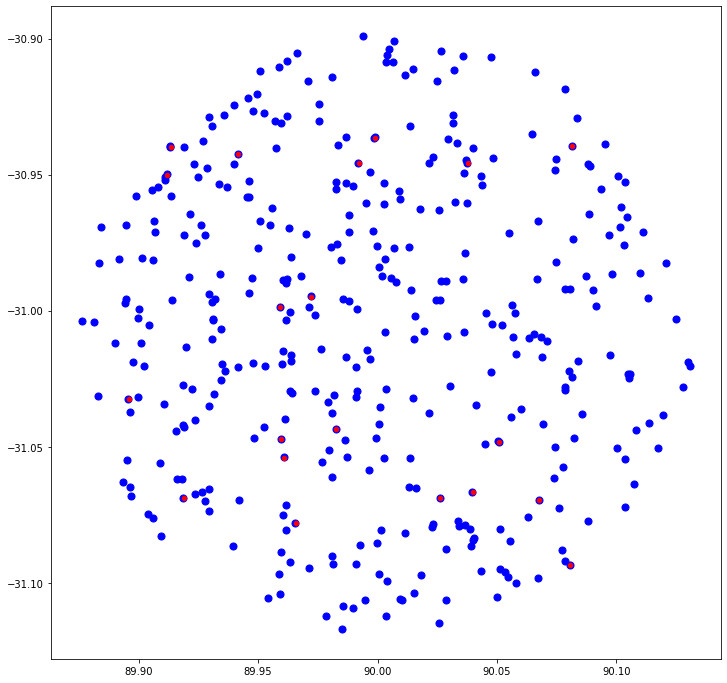

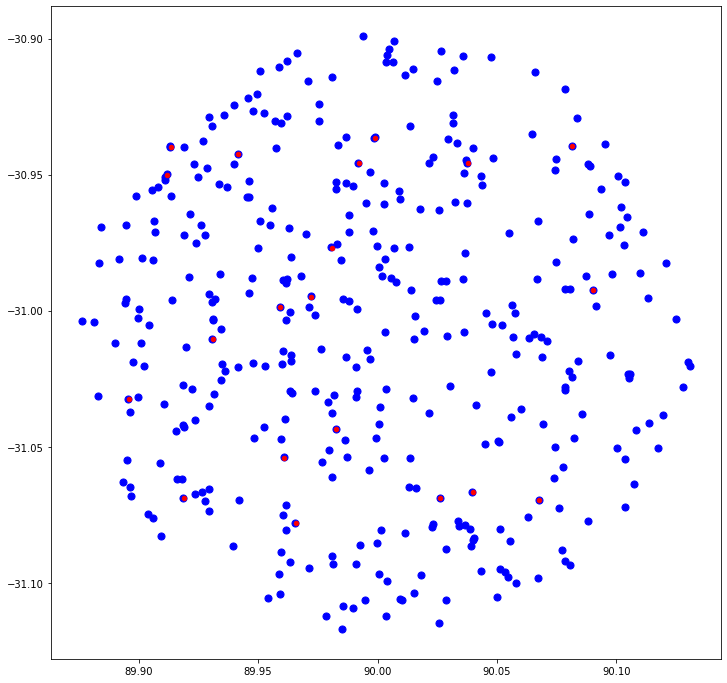

In [82]:
for f in filt:
    plt.figure(figsize=(12,12))
    plt.scatter(r['ra'],r['dec'],c='b',s=50)
    plt.scatter(standards['RA'][mask[f]],standards['Dec'][mask[f]], c='r',s=20)
    #plt.scatter(r['ra'][gaiamask[f]],r['dec'][gaiamask[f]],c='black',s=10)
    plt.show()

In [73]:
# Header titles:
#  phot_g_mean_mag
#  phot_bp_mean_mag
#  phot_rp_mean_mag
gaia_mag = {}
gaia_mag[filt[0]] = np.array(r['phot_g_mean_mag'][gaiamask[filt[0]]])
gaia_mag[filt[2]] = np.array(r['phot_rp_mean_mag'][gaiamask[filt[2]]])

flux = {'gp': np.array([ 305448.24632465,   39778.07420979,  105648.21843843,
       2551167.8547218 ,   50446.7342343 , 1296160.95817579,
         44848.78128847, 1028142.45310747,   86689.49541329,
         76045.3521753 ,  114603.82773365,  124497.67571942,
         59108.88262064,  637974.58137528,   93640.5342565 ,
        138508.81595444,  137597.27343034,  119115.30968919,
         92826.67158186,   66535.98950952]), 'ip': np.array([ 259499.26603077,   45494.10393059,  114657.90140514,
       2695533.3431834 ,   64038.46994782, 1396423.13521724,
       1549835.490526  ,  131351.14784065,   72197.59688711,
         97749.05572845,  116669.02461818,   80572.17189869,
        165113.87576311,  187679.95198857,  128366.62740556,
        694046.67881937,  180465.25513588,  120414.36949187,
         79654.4992175 ,   82587.60798688]), 'rp': np.array([ 321240.21920627,   58086.2304161 ,   53267.9400151 ,
        135651.31069807, 1649551.53408443,   54842.98086081,
       1633531.91601591,  142027.99842079,   87750.85299584,
        121111.79769749,  140706.23382845,   73689.69403475,
        100608.71705821,  184979.28221345,  309585.66854371,
         90405.08005296,  886965.86068166,  192979.51222313,
        142995.87267217,   99118.23268808])}


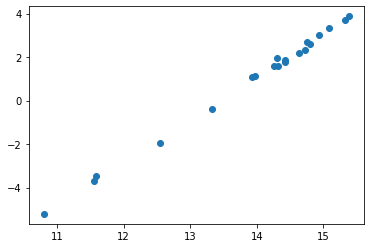

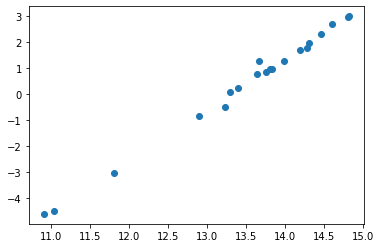

In [81]:
for f in ['gp','rp']:
    plt.scatter(gaia_mag[f],-2.5*np.log10(flux[f])+gaia_mag[f])
    plt.show()